In [7]:
import math

import numpy as np
from scipy import signal, optimize
from matplotlib import pyplot as plt

import rocof_test_data

In [8]:
%matplotlib notebook

In [9]:
fs = 1e3 # Hz
ff = 50 # Hz
duration = 60 # seconds
# test_data = rocof_test_data.sample_waveform(rocof_test_data.test_close_interharmonics_and_flicker(),
#                                             duration=20,
#                                             sampling_rate=fs,
#                                             frequency=ff)[0]
# test_data = rocof_test_data.sample_waveform(rocof_test_data.gen_noise(fmin=10, amplitude=1),
#                                             duration=20,
#                                             sampling_rate=fs,
#                                             frequency=ff)[0]


#gen = rocof_test_data.gen_noise(fmin=10, amplitude=1)
# gen = rocof_test_data.gen_noise(fmin=60, amplitude=0.2)
# gen = rocof_test_data.test_harmonics()
# gen = rocof_test_data.gen_interharmonic(*rocof_test_data.test_interharmonics)
# gen = rocof_test_data.test_amplitude_steps()
# gen = rocof_test_data.test_amplitude_and_phase_steps()
test_data = []
test_labels = [ fun.__name__.replace('test_', '') for fun in rocof_test_data.all_tests ]
for gen in rocof_test_data.all_tests:
    test_data.append(rocof_test_data.sample_waveform(gen(),
                                            duration=duration,
                                            sampling_rate=fs,
                                            frequency=ff)[0])
# d = 10 # seconds
# test_data = np.sin(2*np.pi * ff * np.linspace(0, d, int(d*fs)))

In [10]:
analysis_periods = 50
window_len = fs * analysis_periods/ff
nfft_factor = 1

ffts = []
for item in test_data:
    f, t, Zxx = signal.stft(item,
                fs = fs,
                window='blackman',
                nperseg = window_len,
                nfft = window_len * nfft_factor)
                #boundary = 'zeros')
    ffts.append((f, t, Zxx))

<IPython.core.display.Javascript object>


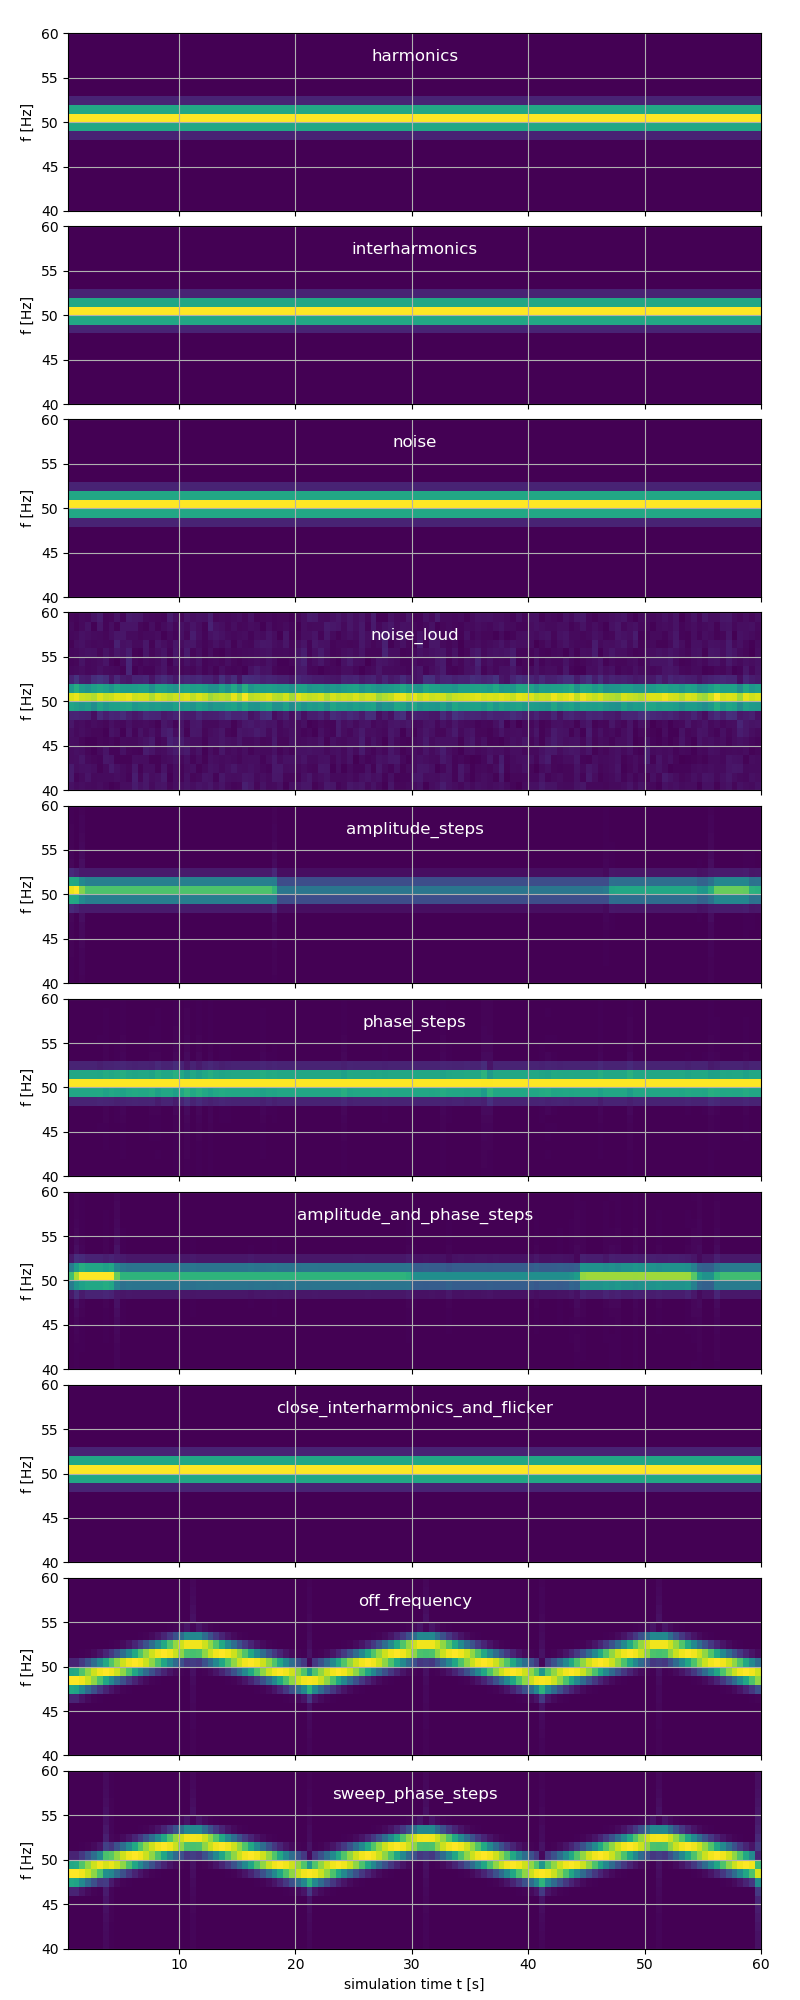

In [11]:
fig, ax = plt.subplots(len(test_data), figsize=(8, 20), sharex=True)
fig.tight_layout(pad=2, h_pad=0.1)

for fft, ax, label in zip(ffts, ax.flatten(), test_labels):
    f, t, Zxx = fft
    ax.pcolormesh(t[1:], f[:250], np.abs(Zxx[:250,1:]))
    ax.set_title(label, pad=-20, color='white')
    ax.grid()
    ax.set_ylabel('f [Hz]')
    ax.set_ylim([40, 60]) # Hz
ax.set_xlabel('simulation time t [s]')
None

<IPython.core.display.Javascript object>


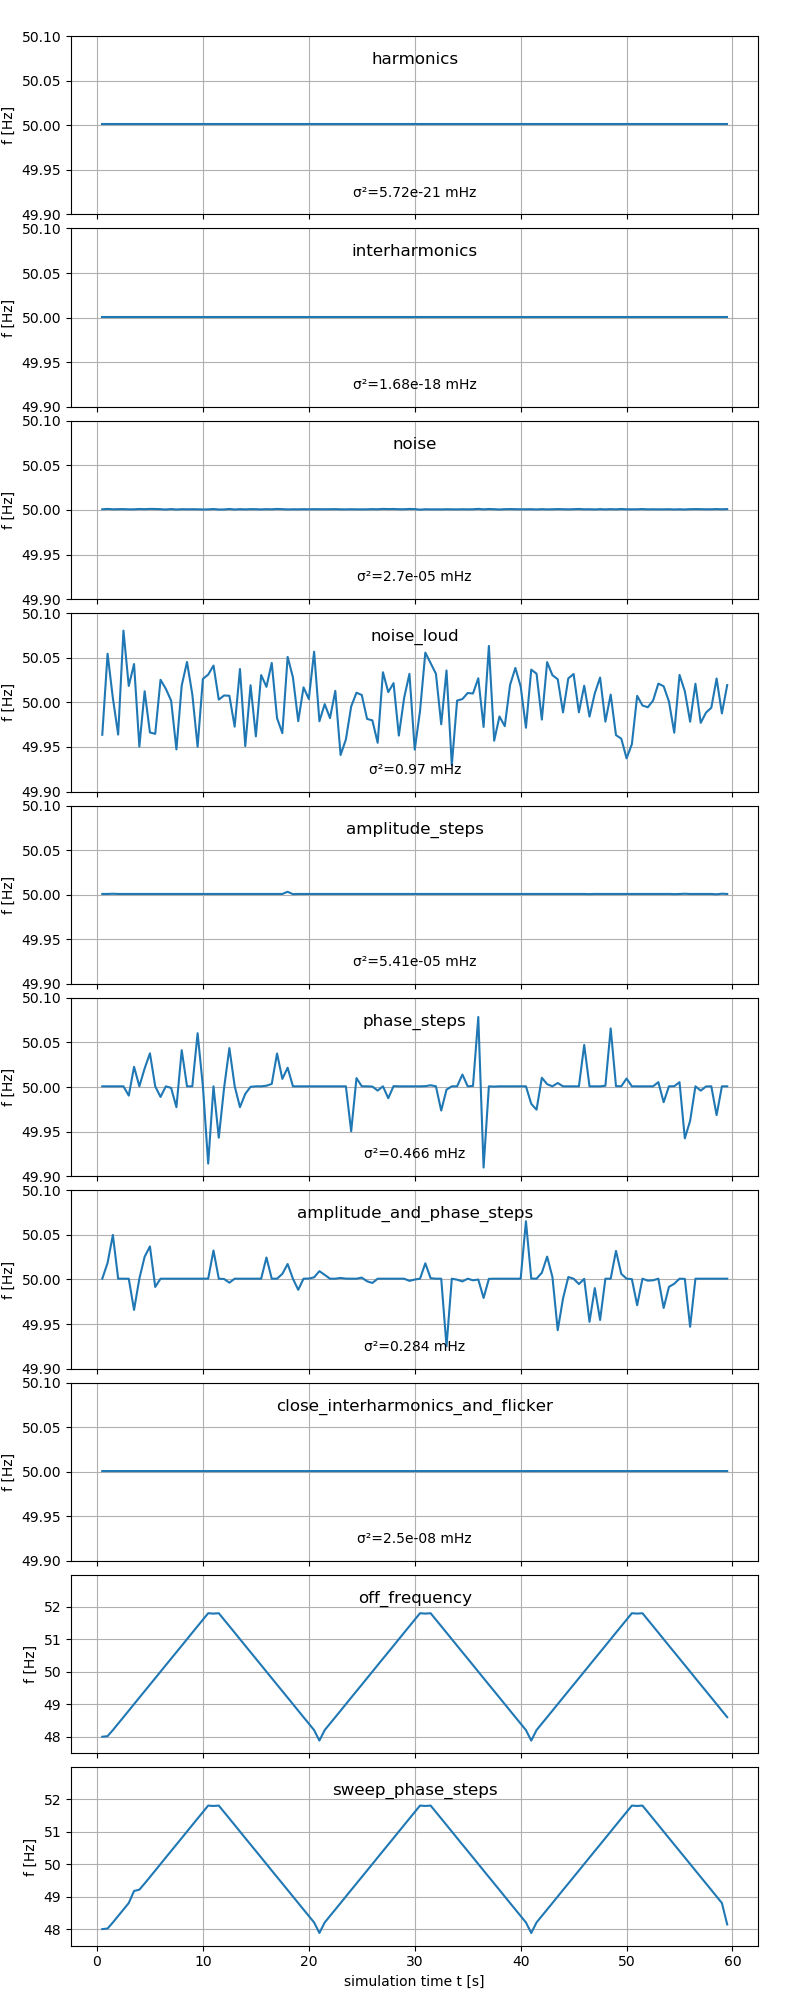

In [12]:
fig, axs = plt.subplots(len(test_data), figsize=(8, 20), sharex=True)
fig.tight_layout(pad=2.2, h_pad=0, w_pad=1)

for fft, ax, label in zip(ffts, axs.flatten(), test_labels):
    f, f_t, Zxx = fft
    
    n_f, n_t = Zxx.shape
    start, stop = 180, 220
    # start, stop = 90, 110
    # start, stop = 15, 35
    bounds_f = slice(start // 4 * nfft_factor, stop // 4 * nfft_factor)
    

    f_mean = np.zeros(Zxx.shape[1])
    for t in range(1, Zxx.shape[1] - 1):
        frame_f = f[bounds_f]
        frame_Z = np.abs(Zxx[bounds_f, t])
        # frame_f = f[180:220]
        # frame_Z = np.abs(Zxx[180:220, 40])
        # frame_f = f[15:35]
        # frame_Z = np.abs(Zxx[15:35, 40])
        # plt.plot(frame_f, frame_Z)

        # peak_f = frame_f[np.argmax(frame)]
        # plt.axvline(peak_f, color='red')

        def gauss(x, *p):
            A, mu, sigma, o = p
            return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + o
        
        f_start = frame_f[np.argmax(frame_Z)]
        p0 = [.5, f_start, 1., 0]
        coeff, var = optimize.curve_fit(gauss, frame_f, frame_Z, p0=p0)
        # plt.plot(frame_f, gauss(frame_f, *coeff))
        #print(coeff)
        A, mu, sigma, o = coeff
        f_mean[t] = mu
    ax.plot(f_t[1:-1], f_mean[1:-1])
    ax.set_title(label, pad=-20)
    ax.set_ylabel('f [Hz]')
    ax.grid()
    if not label in ['off_frequency', 'sweep_phase_steps']:
        ax.set_ylim([49.90, 50.10])
        ax.text(0.5, 0.1, f'σ²={np.var(f_mean[1:-1]) * 1e3:.3g} mHz', transform=ax.transAxes, ha='center')
    else:
        f_min, f_max = min(f_mean[1:-1]), max(f_mean[1:-1])
        delta = f_max - f_min
        ax.set_ylim(f_min - delta * 0.1, f_max + delta * 0.3)
        
ax.set_xlabel('simulation time t [s]')
None